<a href="https://colab.research.google.com/github/Aishika3/Image_Classification_CNN/blob/main/Image_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 226kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.25MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]


Number of (train, test) examples = (60000, 10000)


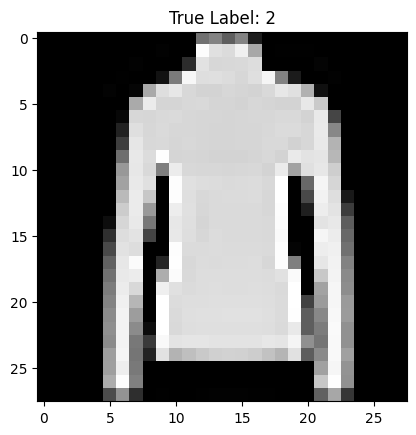

Using cpu device


Epoch 1 ------------------
Batch 0: Train Loss = 2.2435
Batch 100: Train Loss = 0.4677
Batch 200: Train Loss = 0.4419
Batch 300: Train Loss = 0.4434
Batch 400: Train Loss = 0.3262
Batch 500: Train Loss = 0.3829
Batch 600: Train Loss = 0.3002
Batch 700: Train Loss = 0.2524
Batch 800: Train Loss = 0.3903
Batch 900: Train Loss = 0.4469
Train accuracy: 0.879, Train loss: 0.341
Test accuracy: 0.870, Test loss: 0.376

Epoch 2 ------------------
Batch 0: Train Loss = 0.3812
Batch 100: Train Loss = 0.1424
Batch 200: Train Loss = 0.2659
Batch 300: Train Loss = 0.2251
Batch 400: Train Loss = 0.3054
Batch 500: Train Loss = 0.2969
Batch 600: Train Loss = 0.3413
Batch 700: Train Loss = 0.1916
Batch 800: Train Loss = 0.3792
Batch 900: Train Loss = 0.3542
Train accuracy: 0.906, Train loss: 0.267
Test accuracy: 0.886, Test loss: 0.313

Epoch 3 ------------------
Batch 0: Train Loss = 0.2022
Batch 100: Train Loss = 0.3010
Batch 200: Train Loss = 0.4260
Batch 300: Train Loss = 0.1598


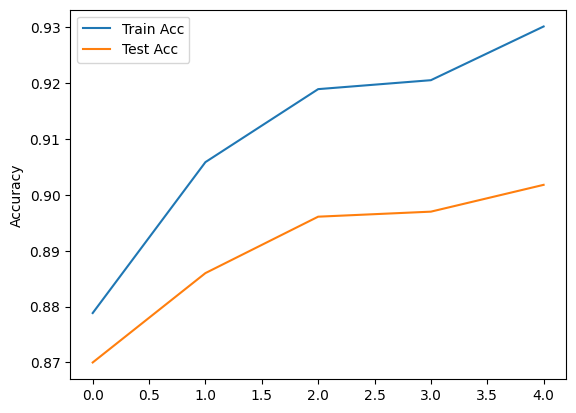

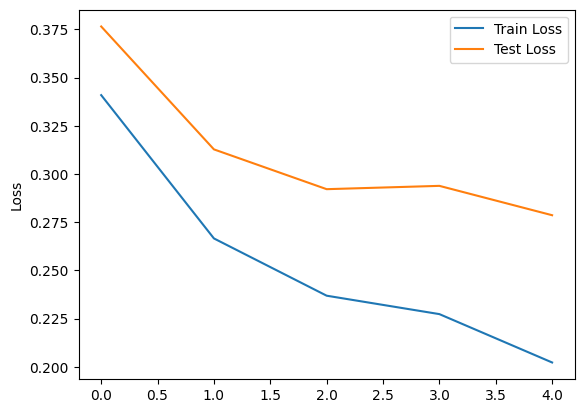

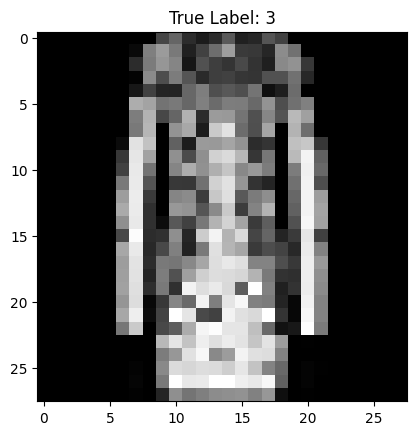

Predicted Label: 3


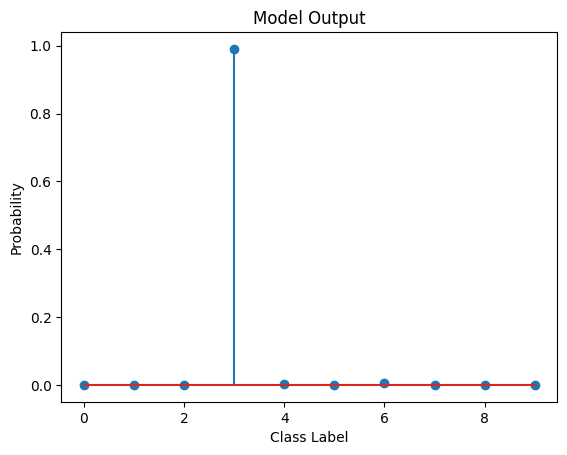

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Normalize inputs to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Load Dataset
def load_dataset(name="FashionMNIST"):
    if name == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(root="FashionMNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root="FashionMNIST", train=False, download=True, transform=transform)
    elif name == "MNIST":
        train_dataset = datasets.MNIST(root="MNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="MNIST", train=False, download=True, transform=transform)
    return train_dataset, test_dataset

train_dataset, test_dataset = load_dataset("FashionMNIST")
print(f'Number of (train, test) examples = {len(train_dataset), len(test_dataset)}')

# Visualize one example
idx = np.random.choice(len(train_dataset))
x = train_dataset[idx][0]
plt.imshow(x[0], cmap='gray')
plt.title(f'True Label: {train_dataset[idx][1]}')
plt.show()

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device\n")

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3),          # [batch, 32, 26, 26]
            nn.LeakyReLU(),
            nn.MaxPool2d(2),              # [batch, 32, 13, 13]
            nn.Flatten(),
            nn.Linear(32*13*13, 10)       # Output: 10 classes
        )
    def forward(self, x):
        return self.layers_stack(x)

# Evaluate Accuracy + Loss
def performance_estimate(dataset, model, loss_fn, mode):
    dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=False)
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()
    accuracy = correct / len(dataset)
    avg_loss = loss / len(dataloader)
    print(f"{mode} accuracy: {accuracy:.3f}, {mode} loss: {avg_loss:.3f}")
    return accuracy, avg_loss

# One Epoch Training
def one_epoch(model, loss_fn, optimizer, dataset):
    dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print(f"Batch {batch}: Train Loss = {loss.item():.4f}")

# Full Training Function
def training(train_dataset, test_dataset, lr=1e-3, weight_decay=1e-8, epochs=5):
    model = CNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs):
        print(f"\nEpoch {t+1} ------------------")
        one_epoch(model, loss_fn, optimizer, train_dataset)
        acc_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'Train')
        acc_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'Test')
        A_Train.append(acc_train)
        L_Train.append(loss_train)
        A_Test.append(acc_test)
        L_Test.append(loss_test)

    return A_Train, L_Train, A_Test, L_Test, model.state_dict()

# Train Model
A_Train, L_Train, A_Test, L_Test, model_state_dict = training(train_dataset, test_dataset, epochs=5)

# Plot Accuracy & Loss
plt.plot(A_Train, label='Train Acc')
plt.plot(A_Test, label='Test Acc')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(L_Train, label='Train Loss')
plt.plot(L_Test, label='Test Loss')
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save model
torch.save(model_state_dict, "model_FashionMNIST_CNN.pth")

# Load and Predict
model = CNN().to(device)
model.load_state_dict(torch.load("model_FashionMNIST_CNN.pth"))
model.eval()

idx = np.random.choice(len(test_dataset))
x = test_dataset[idx][0]
y_true = test_dataset[idx][1]
plt.imshow(x[0], cmap='gray')
plt.title(f'True Label: {y_true}')
plt.show()

out = model(x.unsqueeze(0).to(device)).detach().cpu().flatten()
prob = F.softmax(out, dim=0)
pred = prob.argmax().item()
print(f'Predicted Label: {pred}')

plt.stem(np.arange(10), prob)
plt.ylabel('Probability')
plt.xlabel('Class Label')
plt.title('Model Output')
plt.show()
